In [1]:

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

2023-05-14 11:29:29.259840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline


In [3]:
# csv data from https://www.gunviolencearchive.org/reports/mass-shooting


df1 = pd.read_csv('mass_shootings.csv', parse_dates=['Incident Date'])
df2 = pd.read_csv('mass_shootings2022.csv', parse_dates=['Incident Date'])
df3 = pd.read_csv('mass_shootings2021.csv', parse_dates=['Incident Date'])

frames = [df1, df2, df3]
df = pd.concat(frames, ignore_index=True, sort=True)
df.head()

,# Injured,# Killed,Address,City Or County,Full Address,Incident Date,Incident ID,Latitude,Longitude,Operations,State
0,6,0,485 N Clinton Ave,Rochester,"485 N Clinton Ave Rochester, New York",2020-07-11,1731349.0000,43.1666,-77.6109,NaN,New York
1,5,0,7900 block of Janna Lee Ave,Alexandria,"7900 block of Janna Lee Ave Alexandria, Virginia",2020-07-07,1727743.0000,38.7461,-77.0948,NaN,Virginia
2,3,4,Harrison St and Carroll St,Paterson,"Harrison St and Carroll St Paterson, New Jersey",2020-07-07,1728683.0000,40.9228,-74.1616,NaN,New Jersey
3,6,0,1305 W 76th St,Chicago,"1305 W 76th St Chicago, Illinois",2020-07-06,1727567.0000,41.7555,-87.6567,NaN,Illinois
4,4,0,3700 block of W Jackson Blvd,Chicago,"3700 block of W Jackson Blvd Chicago, Illinois",2020-07-05,1725883.0000,41.8772,-87.7182,NaN,Illinois


In [35]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df=remove_outlier(df,'# Injured')
df=remove_outlier(df,'# Killed')

In [ ]:
#df['d_year'] = pd.to_datetime(df['Incident Date']).dt.year
#df['d_month'] = pd.to_datetime(df['Incident Date']).dt.month
#df['d_week'] = pd.to_datetime(df['Incident Date']).dt.week
#df['d_quarter'] = pd.to_datetime(df['Incident Date']).dt.quarter
#df['d_day'] = pd.to_datetime(df['Incident Date']).dt.day

#df.drop(df[df['# Injured'] > 400].index, inplace = True)

In [4]:
df.drop_duplicates()

,# Injured,# Killed,Address,City Or County,Full Address,Incident Date,Incident ID,Latitude,Longitude,Operations,State
0,6,0,485 N Clinton Ave,Rochester,"485 N Clinton Ave Rochester, New York",2020-07-11,1731349.0000,43.1666,-77.6109,NaN,New York
1,5,0,7900 block of Janna Lee Ave,Alexandria,"7900 block of Janna Lee Ave Alexandria, Virginia",2020-07-07,1727743.0000,38.7461,-77.0948,NaN,Virginia
2,3,4,Harrison St and Carroll St,Paterson,"Harrison St and Carroll St Paterson, New Jersey",2020-07-07,1728683.0000,40.9228,-74.1616,NaN,New Jersey
3,6,0,1305 W 76th St,Chicago,"1305 W 76th St Chicago, Illinois",2020-07-06,1727567.0000,41.7555,-87.6567,NaN,Illinois
4,4,0,3700 block of W Jackson Blvd,Chicago,"3700 block of W Jackson Blvd Chicago, Illinois",2020-07-05,1725883.0000,41.8772,-87.7182,NaN,Illinois
...,...,...,...,...,...,...,...,...,...,...,...
3705,8,0,10525 NW 24th Ave,Miami,NaN,2021-01-03,1893744.0000,NaN,NaN,NaN,Florida
3706,7,0,3211 Towson Ave,Fort Smith,NaN,2021-01-01,1892034.0000,NaN,NaN,NaN,Arkansas
3707,3,1,2650 Dumas Dr,Amarillo,NaN,2021-01-01,1892704.0000,NaN,NaN,NaN,Texas
3708,4,1,2637 S Walker St,Sioux City,NaN,2021-01-01,1892114.0000,NaN,NaN,NaN,Iowa


In [5]:
df.dropna()

,# Injured,# Killed,Address,City Or County,Full Address,Incident Date,Incident ID,Latitude,Longitude,Operations,State


In [ ]:
df.head()

In [189]:
ts_df.count()

# Injured       3710
# Killed        3710
Full Address    2368
# Victims       3710
Year            3710
Week #          3710
dtype: int64

In [6]:
# convert dataframe to weekly time series

# convert dataframe to weekly time series
df = df.drop('Operations', axis=1)
df['# Victims'] = df.loc[:, ['# Injured', '# Killed']].sum(axis=1)
df.sort_values(['Incident Date', 'State'], inplace=True)
df['Cumulative Victims Same Year'] = df.groupby(df['Incident Date'].dt.year).agg({'# Victims': 'cumsum'})
df.set_index('Incident Date', inplace=True)

ts_df = df.drop(['Address', 'City Or County', 'Incident ID', 'State', 'Latitude', 'Longitude'], axis=1)
ts_df = ts_df.resample('W').sum().drop('Cumulative Victims Same Year', axis=1)
ts_df.index.rename('Week Ending In', inplace=True)
ts_df['Cumulative Victims Same Year'] = ts_df.groupby(ts_df.index.year).agg({'# Victims': 'cumsum'})
ts_df['Year'], ts_df['Week #'] = ts_df.index.year, ts_df.index.week


In [ ]:
# Top 20 incidents sorted by number killed first and then by number injured.
ts_df.nlargest(20, ['# Killed', '# Injured'], keep='all').assign(Rank=lambda x: x[['# Killed', '# Injured']]
.apply(tuple, axis=1).rank(method='dense', ascending=False).astype(int)).set_index('Rank')

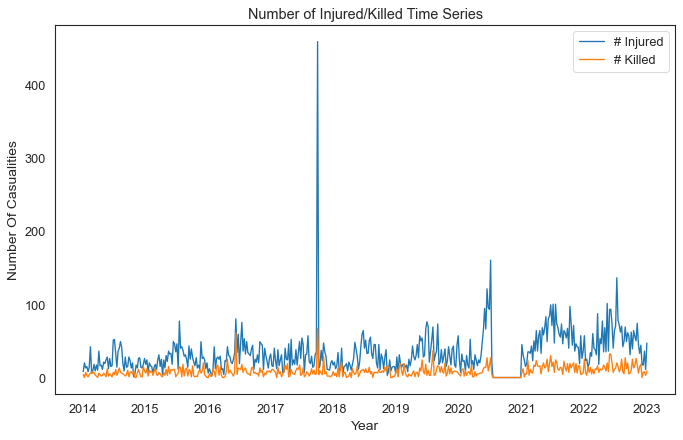

In [7]:
plt.figure(figsize=(10,6), dpi= 80)
category = ['# Injured', '# Killed']

for ct in (category):    
    plt.plot(ct, data=ts_df )
    
plt.gca().set(ylabel='Number Of Casualities', xlabel='Year')
plt.title("Number of Injured/Killed Time Series", fontsize=13)
plt.legend()
plt.show()

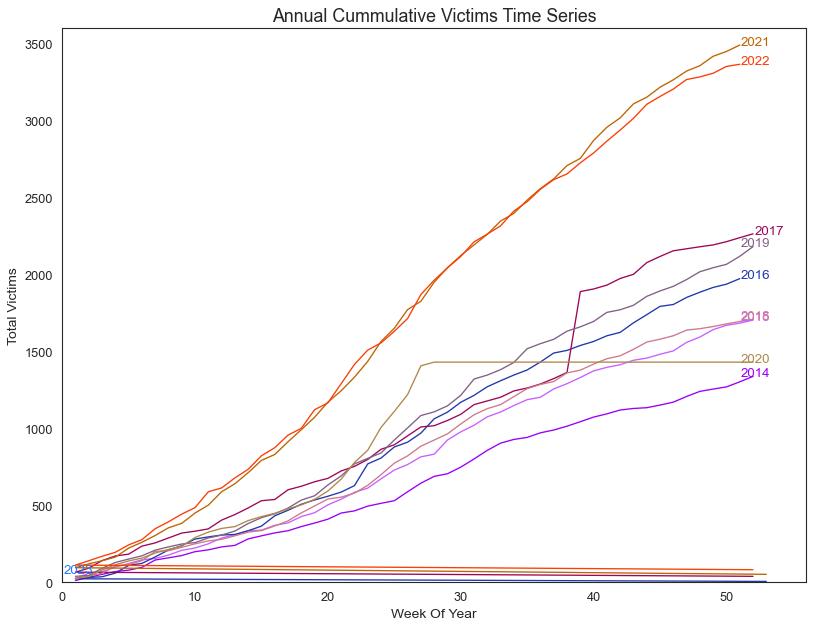

In [10]:
years = ts_df['Year'].unique().tolist()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(12, 9), dpi= 80)
for i, y in enumerate(years):        
    plt.plot('Week #', 'Cumulative Victims Same Year', data=ts_df.drop(ts_df.columns[[0,1,2]], axis=1).loc[ts_df['Year']==y, :],
             color=mycolors[i], label=y)
    plt.text(ts_df.loc[ts_df['Year']==y, :].shape[0]-.9, ts_df.loc[ts_df['Year']==y, 'Cumulative Victims Same Year'][-1:].values[0],
             y, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(0, 56), ylim=(0, 3600), ylabel='Total Victims', xlabel='Week Of Year')
plt.title("Annual Cummulative Victims Time Series", fontsize=16)
plt.show()

In [9]:
import matplotlib as mpl

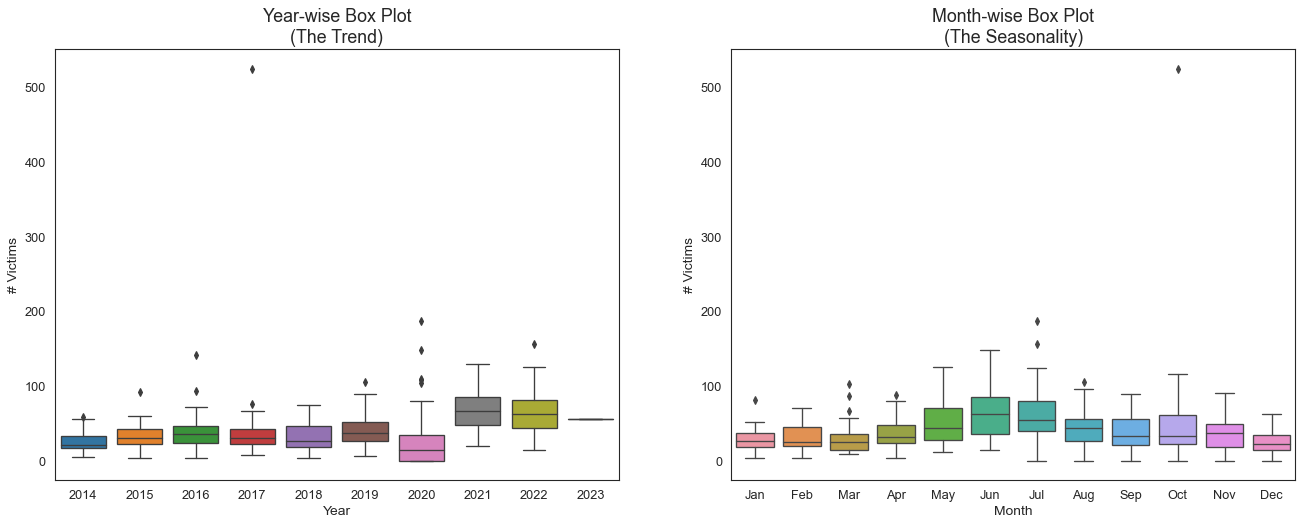

In [204]:
ts_df['Month'] = [d.strftime('%b') for d in ts_df.index]
years = ts_df['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Victims', data=ts_df, ax=axes[0])
sns.boxplot(x='Month', y='# Victims', data=ts_df.loc[~ts_df.Year.isin([2013, 2023]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

In [205]:
ts_df.count()

# Injured                       470
# Killed                        470
# Victims                       470
Cumulative Victims Same Year    470
Year                            470
Week #                          470
Month                           470
dtype: int64

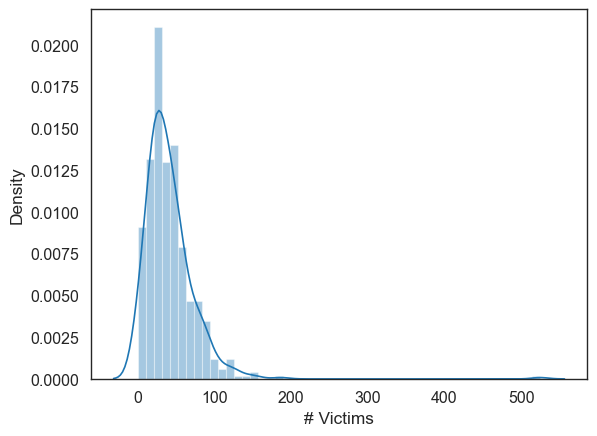

In [206]:
sns.distplot(ts_df['# Victims']);

In [11]:
#ts_df.where(ts_df['# Victims'].values==0)
ts_df.drop(ts_df[ts_df['# Victims'] ==0].index, inplace=True)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

In [14]:
#ts_df.where(ts_df['# Victims'].values==0)
ts_df.drop(ts_df[ts_df['# Victims'] ==0].index, inplace=True)

In [15]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [44]:
data = ts_df['# Victims'].values.astype('float32')
data = data.reshape(-1, 1)
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

In [45]:
data = ts_df['# Victims'].values.astype('float32')
data = data.reshape(-1, 1)

# normalize the dataset
pscaler = PowerTransformer(method='box-cox', standardize=False)
data = pscaler.fit_transform(data)
mscaler = MinMaxScaler(feature_range=(0, 1))
data = mscaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],  trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],1))

In [211]:
data=ts_df['# Victims']
data

Week Ending In
2014-01-05    12
2014-01-12    20
2014-01-19    20
2014-01-26    18
2014-02-02     9
              ..
2022-12-04    17
2022-12-11    24
2022-12-18    44
2022-12-25    14
2023-01-01    56
Freq: W-SUN, Name: # Victims, Length: 470, dtype: int64

In [46]:
# create and fit stateless LSTM network with look_back = 1
model = Sequential()
model.add(LSTM(4, input_shape=( look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
287/287 - 1s - loss: 0.0154 - 905ms/epoch - 3ms/step
Epoch 2/100
287/287 - 0s - loss: 0.0135 - 303ms/epoch - 1ms/step
Epoch 3/100
287/287 - 0s - loss: 0.0137 - 297ms/epoch - 1ms/step
Epoch 4/100
287/287 - 0s - loss: 0.0136 - 301ms/epoch - 1ms/step
Epoch 5/100
287/287 - 0s - loss: 0.0134 - 301ms/epoch - 1ms/step
Epoch 6/100
287/287 - 0s - loss: 0.0136 - 300ms/epoch - 1ms/step
Epoch 7/100
287/287 - 0s - loss: 0.0137 - 296ms/epoch - 1ms/step
Epoch 8/100
287/287 - 0s - loss: 0.0136 - 295ms/epoch - 1ms/step
Epoch 9/100
287/287 - 0s - loss: 0.0135 - 295ms/epoch - 1ms/step
Epoch 10/100
287/287 - 0s - loss: 0.0136 - 295ms/epoch - 1ms/step
Epoch 11/100
287/287 - 0s - loss: 0.0136 - 307ms/epoch - 1ms/step
Epoch 12/100
287/287 - 0s - loss: 0.0135 - 296ms/epoch - 1ms/step
Epoch 13/100
287/287 - 0s - loss: 0.0137 - 295ms/epoch - 1ms/step
Epoch 14/100
287/287 - 0s - loss: 0.0134 - 296ms/epoch - 1ms/step
Epoch 15/100
287/287 - 0s - loss: 0.0137 - 294ms/epoch - 1ms/step
Epoch 16/100
287/28

In [40]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


array([[7.9692898e+10],
       [7.9692898e+10],
       [7.9692898e+10],
       [7.9692816e+10],
       [7.9692980e+10],
       [7.9692898e+10],
       [7.9692898e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9692980e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9692980e+10],
       [7.9693144e+10],
       [7.9693144e+10],
       [7.9692980e+10],
       [7.9692816e+10],
       [7.9692734e+10],
       [7.9692816e+10],
       [7.9692898e+10],
       [7.9692980e+10],
       [7.9692898e+10],
       [7.9692898e+10],
       [7.9692898e+10],
       [7.9692980e+10],
       [7.9692898e+10],
       [7.9692980e+10],
       [7.969289

In [42]:
from sklearn.metrics import mean_absolute_error as mae

In [47]:
# invert predictions
trainPredict = mscaler.inverse_transform(trainPredict)
trainPredict = pscaler.inverse_transform(trainPredict)
trainY = mscaler.inverse_transform([trainY])
trainY = pscaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = mscaler.inverse_transform(testPredict)
testPredict = pscaler.inverse_transform(testPredict)
testY = mscaler.inverse_transform([testY])
testY = pscaler.inverse_transform(testY.reshape(-1, 1))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY.reshape(1, -1)[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(1, -1)[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# calculate root mean squared error
trainScore = mae(trainY.reshape(1, -1)[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mae(testY.reshape(1, -1)[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 34.54 RMSE
Test Score: 34.45 RMSE
Train Score: 15.25 MAE
Test Score: 25.36 MAE


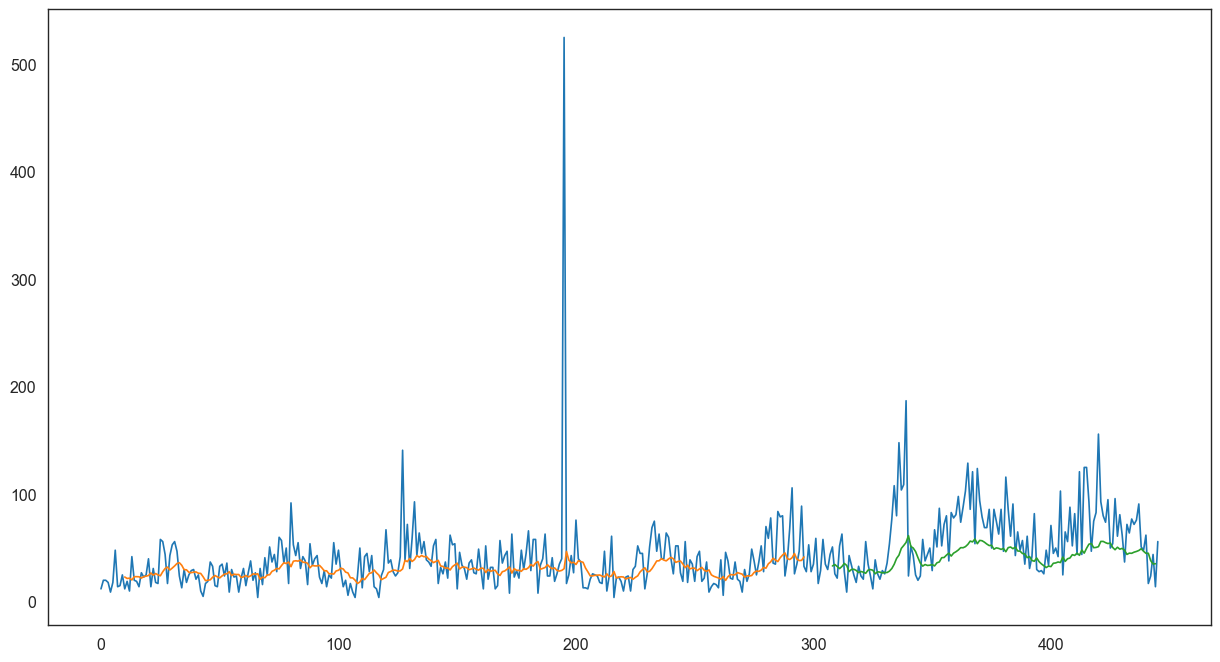

In [48]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
#inverse transform data
data = mscaler.inverse_transform(data)
data = pscaler.inverse_transform(data)
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<Axes: >

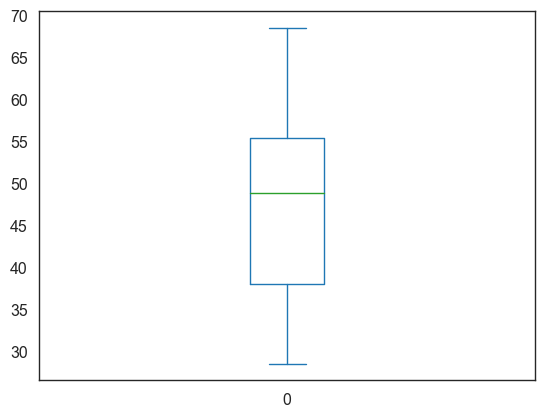

In [26]:
pd.DataFrame(testPredict).plot(kind='box')

<Axes: >

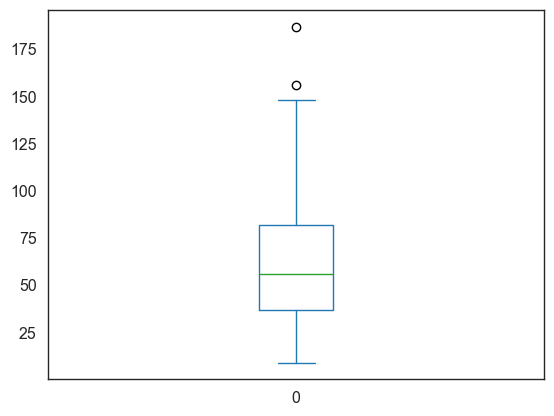

In [51]:
pd.DataFrame(testY).plot(kind='box')

In [52]:
data = ts_df['# Victims'].values.astype('float32')
data = data.reshape(-1, 1)

# normalize the dataset
pscaler = PowerTransformer(method='box-cox', standardize=False)
data = pscaler.fit_transform(data)
mscaler = MinMaxScaler(feature_range=(-1, 1))
data = mscaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit stateful LSTM network with look_back = 3
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(1080):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = mscaler.inverse_transform(trainPredict)
trainPredict = pscaler.inverse_transform(trainPredict)
trainY = mscaler.inverse_transform([trainY])
trainY = pscaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = mscaler.inverse_transform(testPredict)
testPredict = pscaler.inverse_transform(testPredict)
testY = mscaler.inverse_transform([testY])
testY = pscaler.inverse_transform(testY.reshape(-1, 1))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY.reshape(1, -1)[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(1, -1)[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

292/292 - 1s - loss: 0.0798 - 1s/epoch - 4ms/step
292/292 - 0s - loss: 0.0561 - 259ms/epoch - 886us/step
292/292 - 0s - loss: 0.0548 - 243ms/epoch - 833us/step
292/292 - 0s - loss: 0.0541 - 219ms/epoch - 750us/step
292/292 - 0s - loss: 0.0537 - 220ms/epoch - 755us/step
292/292 - 0s - loss: 0.0535 - 217ms/epoch - 743us/step
292/292 - 0s - loss: 0.0533 - 216ms/epoch - 741us/step
292/292 - 0s - loss: 0.0532 - 218ms/epoch - 745us/step
292/292 - 0s - loss: 0.0532 - 219ms/epoch - 751us/step
292/292 - 0s - loss: 0.0531 - 218ms/epoch - 745us/step
292/292 - 0s - loss: 0.0530 - 215ms/epoch - 738us/step
292/292 - 0s - loss: 0.0530 - 225ms/epoch - 772us/step
292/292 - 0s - loss: 0.0530 - 217ms/epoch - 742us/step
292/292 - 0s - loss: 0.0529 - 217ms/epoch - 742us/step
292/292 - 0s - loss: 0.0529 - 216ms/epoch - 741us/step
292/292 - 0s - loss: 0.0529 - 218ms/epoch - 745us/step
292/292 - 0s - loss: 0.0528 - 217ms/epoch - 743us/step
292/292 - 0s - loss: 0.0528 - 218ms/epoch - 746us/step
292/292 - 0s - 

<Axes: >

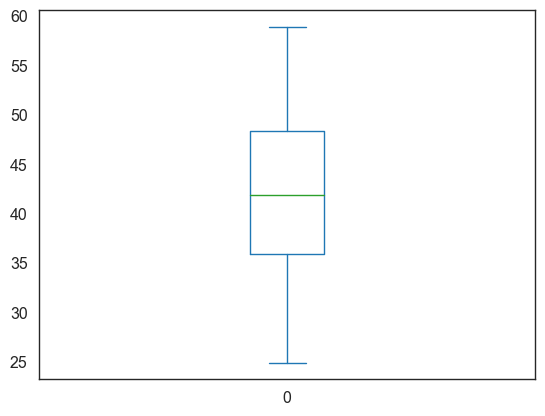

In [36]:
pd.DataFrame(testPredict).plot(kind='box')

<Axes: >

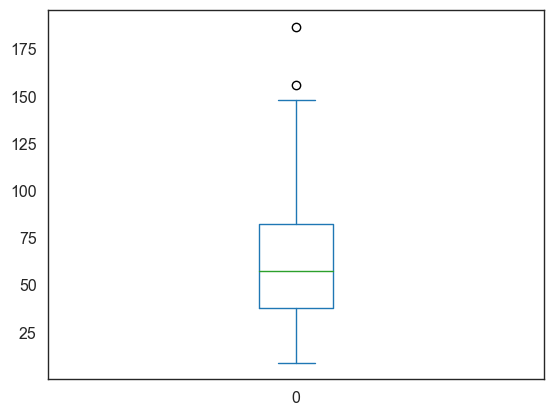

In [35]:
# calculate root mean squared error
trainScore = mae(trainY.reshape(1, -1)[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mae(testY.reshape(1, -1)[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

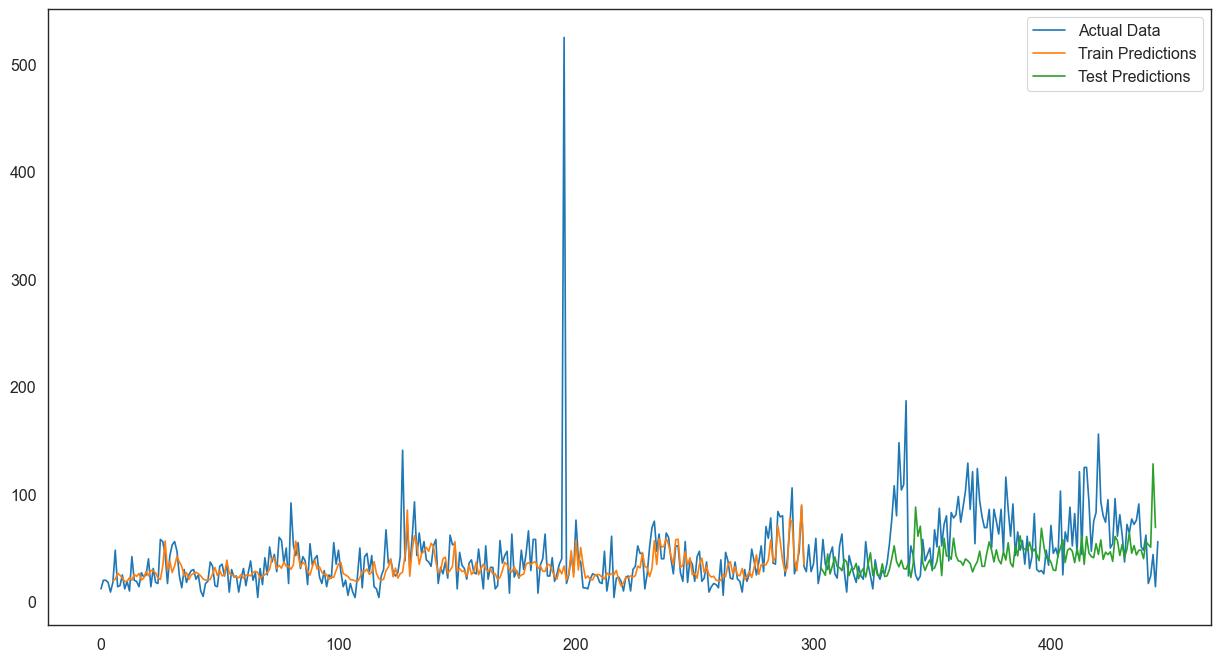

In [30]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

#inverse transform data
data = mscaler.inverse_transform(data)
data = pscaler.inverse_transform(data)

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(data, label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend(loc='best')
plt.show()


In [32]:
data = ts_df['# Victims'].values.astype('float32')
data = data.reshape(-1, 1)

# normalize the dataset
pscaler = PowerTransformer(method='box-cox', standardize=False)
data = pscaler.fit_transform(data)
mscaler = MinMaxScaler(feature_range=(-1, 1))
data = mscaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit stateful LSTM network with look_back = 3
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(1080):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = mscaler.inverse_transform(trainPredict)
trainPredict = pscaler.inverse_transform(trainPredict)
trainY = mscaler.inverse_transform([trainY])
trainY = pscaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = mscaler.inverse_transform(testPredict)
testPredict = pscaler.inverse_transform(testPredict)
testY = mscaler.inverse_transform([testY])
testY = pscaler.inverse_transform(testY.reshape(-1, 1))



282/282 - 1s - loss: 0.0562 - 1000ms/epoch - 4ms/step
282/282 - 0s - loss: 0.0551 - 380ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0548 - 380ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0545 - 378ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0543 - 379ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0542 - 379ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0541 - 377ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0540 - 376ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0540 - 408ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0539 - 412ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0539 - 390ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0538 - 378ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0538 - 378ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0538 - 378ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0537 - 379ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0537 - 377ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0537 - 378ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0537 - 382ms/epoch - 1ms/step
282/282 - 0s - loss: 0.0537 - 380ms/epoch - 1

In [33]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY.reshape(1, -1)[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(1, -1)[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 33.09 RMSE
Test Score: 39.31 RMSE


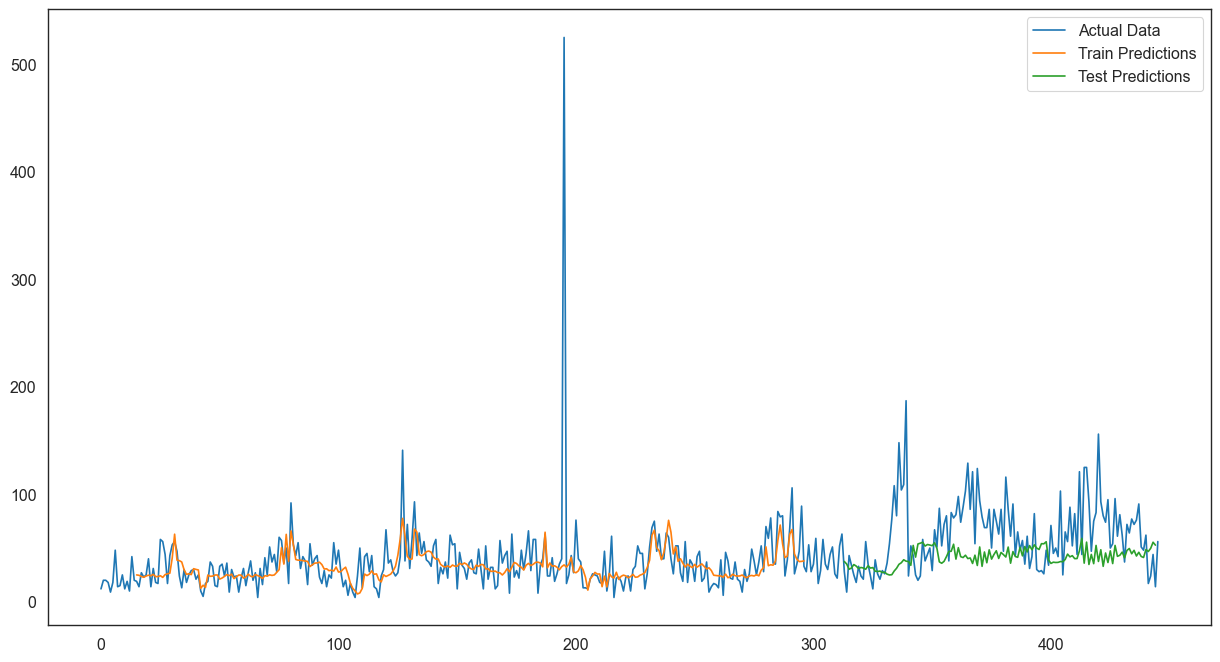

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

#inverse transform data
data = mscaler.inverse_transform(data)
data = pscaler.inverse_transform(data)

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(data, label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend(loc='best')
plt.show()

#Reference:

T. (n.d.). Mass-Shootings-Time-Series/MassShootings.ipynb at master · thomsu/Mass-Shootings-Time-Series. GitHub. https://github.com/thomsu/Mass-Shootings-Time-Series